In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import sys

dir_path = os.path.abspath('')
sys.path.append(dir_path + '/../')

from interpolazione import Interpolazione, final_val

dir_path = os.path.abspath('')
FILE = dir_path + '/data/' + 'RLC critico.csv'
fr = pd.read_csv(FILE)

In [2]:
t = np.array(fr['t (us)']) * 10**-6
V = np.array(fr['V (Volt)'])
sigmaV = np.sqrt((V * 0.01)**2 + (0.04)**2)

C =  104.7* 10**-9 # ± 0.3)e-9 F
sigmaC = 1.1 * 10**-9 # 

R = 1760 + 58.5 #ohm
sigmaR = 1760*0.01 + 58.5*0.01 # ohm

L = 88.8 * 10**-3 #Hr
sigmaL = 0.9* 10**-3 #Hr

R_L = 58.5 #ohm 1%
Vg = 4 #Volt

w2 = 1 / (L*C)
sigmaw2 = np.abs(1/(L*C))*np.sqrt((sigmaL/L)**2 + (sigmaC/C)**2)

γ = R / (2*L)
dγ_dR = 1 / (2 * L)
dγ_dL = -R / (2 * L**2)
sigmaγ = np.sqrt((dγ_dR * sigmaR)**2 + (dγ_dL * sigmaL)**2)

β = np.sqrt(np.abs(w2 - γ**2))
dβ_dw = 0.5 / np.sqrt(np.abs(w2 - γ**2))
dβ_dγ = -γ / np.sqrt(np.abs(w2 - γ**2))
sigmaβ = np.sqrt((dβ_dw * sigmaw2)**2 + (dβ_dγ * sigmaγ)**2)

print('---------------- EXPECTED VALUES ----------------')
print('w2 =', final_val(w2, sigmaw2,exp=7))
print('γ =', final_val(γ, sigmaγ,exp=3))
print('β =', final_val(β, sigmaβ,exp=2))

---------------- EXPECTED VALUES ----------------
w2 = (10.76 ± 0.16)e7 
γ = (10.24 ± 0.15)e3 
β = (16.47 ± 10.24)e2 


In [3]:
def VR_critico(t,A,γ):
    return A * t * np.exp(-γ*t)

def VR_sottosmorzato(t,V0,γ,β):
    return V0*np.exp(-γ*t)*np.sin(β*t)

def VR_sovrasmorzato(t,V0,γ,β):
    return V0 * np.exp(-γ*t) * (np.exp(β*t) - np.exp(-β*t))

In [4]:
ic = Interpolazione(t,V,VR_critico,sigmaV,p0=[Vg,γ])
ist = Interpolazione(t,V,VR_sottosmorzato,sigmaV,p0=[Vg,γ,β])
# sv = Interpolazione(t,V,VR_sovrasmorzato,sigmaV,p0=[Vg,γ,β]) # NOTA: NON TROVA PARAMETRI OTTIMALI PER DESCRIVERE IL SOVRASMIRZATO

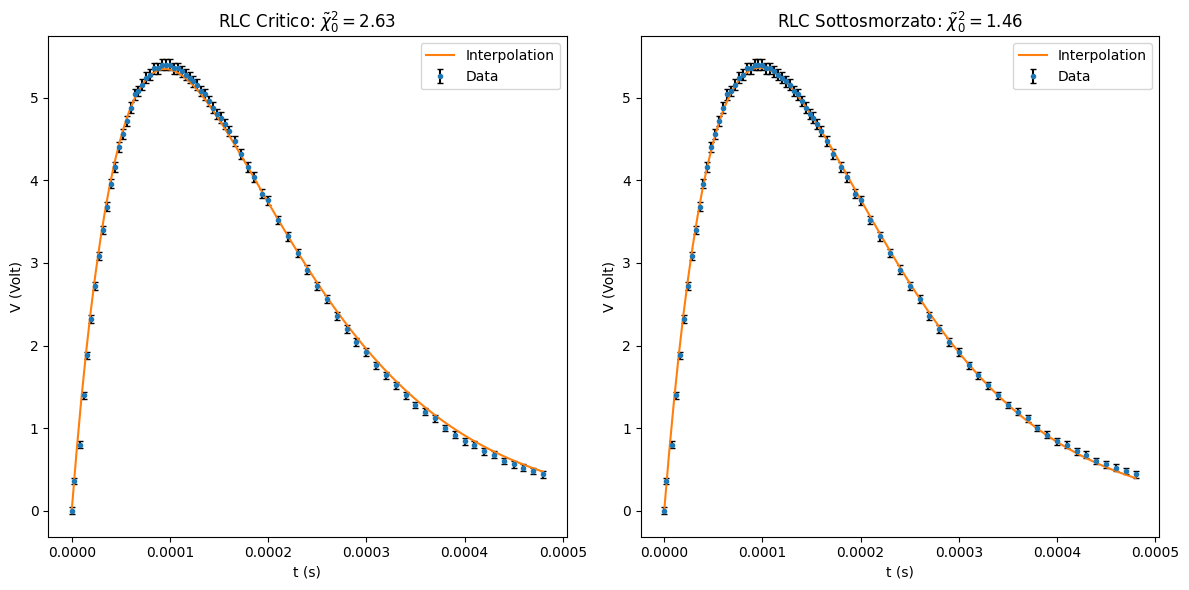

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot on the left subplot
ax1.errorbar(t, V, yerr=sigmaV, fmt='.', label='Data',ecolor='black',capsize=2)
ax1.plot(ic.x_best, ic.y_best, label='Interpolation')
ax1.set_xlabel('t (s)')
ax1.set_ylabel('V (Volt)')
ax1.set_title('RLC Critico: $\\tilde{\chi}^2_0=$' + f"{ic.rchisquare}")
ax1.legend()

# Plot on the right subplot
ax2.errorbar(t, V, yerr=sigmaV, fmt='.', label='Data',ecolor='black',capsize=2)
ax2.plot(ist.x_best, ist.y_best, label='Interpolation')
ax2.set_xlabel('t (s)')
ax2.set_ylabel('V (Volt)')
ax2.set_title('RLC Sottosmorzato: $\\tilde{\chi}^2_0=$' + f"{ist.rchisquare}")
ax2.legend()

plt.tight_layout()
plt.show()

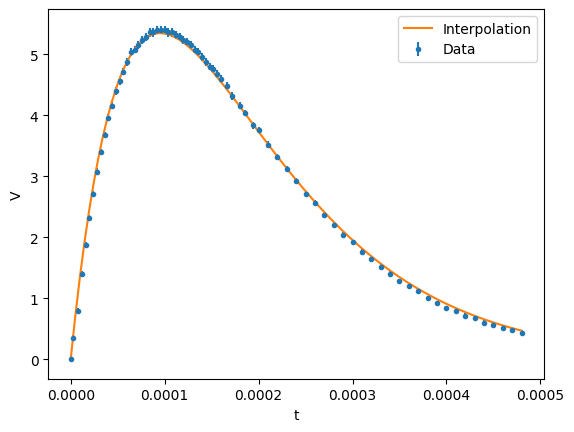

In [6]:
# SOLO PER AVERE IL GRAFICO DEL CRITICO
plt.errorbar(t, V, yerr=sigmaV, fmt='.', label='Data')
plt.plot(ic.x_best, ic.y_best, label='Interpolation')
plt.xlabel('t')
plt.ylabel('V') # TODO: fit con diversi modelli
plt.legend()
plt.show()

# Confronto con valori attesi

In [7]:
ic = Interpolazione(t,V,VR_critico,sigmaV,p0=[Vg,γ])
ist = Interpolazione(t,V,VR_sottosmorzato,sigmaV,p0=[Vg,γ,β])

_,γc = ic.bval
_,sγc = ic.sigma_bval

_,γs,βs = ist.bval
_,sγs,sβs = ist.sigma_bval

print('---------------- EXPECTED VALUES ----------------')
print('w2 =', final_val(w2, sigmaw2,exp=7,decimals=3))
print('γ =', final_val(γ, sigmaγ,exp=3,decimals=3))
print('β =', final_val(β, sigmaβ,exp=2,decimals=3))

print('---------------- FITTED VALUES ----------------')
print('Regime critico:')
print('γc =', final_val(γc, sγc,exp=3,decimals=3))
print()
print('Regime sottosmorzato:')
print('γs =', final_val(γs, sγs,exp=3,decimals=3))
print('βs =', final_val(βs, sβs,exp=2,decimals=3))

print('----------------- T-test -----------------')
print('Regime critico:')
tγc = np.round(np.abs(γc - γ) / np.sqrt(sγc**2 + sigmaγ**2),3)
print('t (γ) =', tγc)
print()
print('Regime sottosmorzato:')
tγs = np.round(np.abs(γs - γ) / np.sqrt(sγs**2 + sigmaγ**2),3)
tβs = np.round(np.abs(βs - β) / np.sqrt(sβs**2 + sigmaβ**2),3)
print('t (γ) =', tγs)
print('t (β) =', tβs)


---------------- EXPECTED VALUES ----------------
w2 = (10.756 ± 0.157)e7 
γ = (10.239 ± 0.146)e3 
β = (16.475 ± 10.238)e2 
---------------- FITTED VALUES ----------------
Regime critico:
γc = (10.512 ± 0.035)e3 

Regime sottosmorzato:
γs = (9.961 ± 0.073)e3 
βs = (31.277 ± 1.87)e2 
----------------- T-test -----------------
Regime critico:
t (γ) = 1.818

Regime sottosmorzato:
t (γ) = 1.711
t (β) = 1.422
